# Adtracking Fraud Detection

by Kyle O'Brien, Catherine Lee, Amit Saxena 

Data is in "data/" and includes the training and testing csv files.
Evaluation metrics will include looking at R^2 and a confusion matrix. Other things to try, CNN (Resnet, inceptionv3)

In [2]:
import numpy as np         # linear algebra
import sklearn as sk       # machine learning
import pandas as pd        # reading in data files, data cleaning
import matplotlib.pyplot as plt   # for plotting
import seaborn as sns      # visualization tool
import tensorflow as tf
import keras

Using TensorFlow backend.


Train_sample: 100,000 randomly-selected rows of training data (because the full training data takes too long)

In [3]:
#load data in 

data = pd.read_csv("data/equalized_train.csv")

data.head()


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83252,3,1,16,379,2017-11-06 15:42:19,NaN,0
1,106590,3,1,25,379,2017-11-06 15:43:23,NaN,0
2,147164,14,1,28,134,2017-11-06 16:00:00,NaN,0
3,39782,2,1,10,205,2017-11-06 16:00:00,NaN,0
4,121646,23,1,13,153,2017-11-06 16:00:00,NaN,0


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91473 entries, 0 to 91472
Data columns (total 8 columns):
ip                 91473 non-null int64
app                91473 non-null int64
device             91473 non-null int64
os                 91473 non-null int64
channel            91473 non-null int64
click_time         91473 non-null object
attributed_time    41473 non-null object
is_attributed      91473 non-null int64
dtypes: int64(6), object(2)
memory usage: 5.6+ MB


Dropping attributed_time because many null values

# Feature Engineering for Date and Time

In [5]:
# Parsed `click_time` feature to seconds since epoch
# Stored new column in `click_time_epoch`
from datetime import datetime, timezone

def epoch_distance(iso):
    dt = datetime.strptime(iso,"%Y-%m-%d %H:%M:%S")
    dt.replace(tzinfo=timezone.utc)
    return dt.timestamp()

#convert click_time to seconds since epoch
data['click_time_epoch'] =  data['click_time'].map(epoch_distance)

In [6]:
def day_seconds(timestamp):
    dt = datetime.fromtimestamp(timestamp,timezone.utc)
    return dt.hour*3600 + dt.minute*60 + dt.second

def day_minutes(timestamp):
    return round(day_seconds(timestamp) / 60)
    

# parsed `click_time` feature to seconds of the current day
# stored new column in `click_time_secs`
data['click_time_secs'] =  data['click_time_epoch'].map(day_seconds)

# parsed `click_time` feature to minutes of the current day
# stored new column in `click_time_mins`
data['click_time_mins'] =  data['click_time_epoch'].map(day_minutes)

In [7]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91473 entries, 0 to 91472
Data columns (total 11 columns):
ip                  91473 non-null int64
app                 91473 non-null int64
device              91473 non-null int64
os                  91473 non-null int64
channel             91473 non-null int64
click_time          91473 non-null object
attributed_time     41473 non-null object
is_attributed       91473 non-null int64
click_time_epoch    91473 non-null float64
click_time_secs     91473 non-null int64
click_time_mins     91473 non-null int64
dtypes: float64(1), int64(8), object(2)
memory usage: 7.7+ MB


In [8]:
data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_time_epoch,click_time_secs,click_time_mins
0,83252,3,1,16,379,2017-11-06 15:42:19,NaN,0,1.509983e+09,56539,942
1,106590,3,1,25,379,2017-11-06 15:43:23,NaN,0,1.509983e+09,56603,943
2,147164,14,1,28,134,2017-11-06 16:00:00,NaN,0,1.509984e+09,57600,960
3,39782,2,1,10,205,2017-11-06 16:00:00,NaN,0,1.509984e+09,57600,960
4,121646,23,1,13,153,2017-11-06 16:00:00,NaN,0,1.509984e+09,57600,960


In [9]:
#time_explore = data[['click_time_secs','is_attributed']]



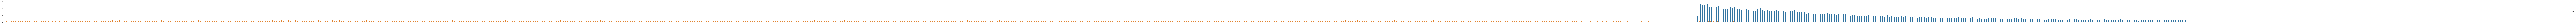

In [10]:
with sns.axes_style('white'):
    g = sns.catplot("click_time_mins", data=data, aspect=100, kind='count',
                       hue='is_attributed')
    g.set_xticklabels(step=10)

In [11]:
arr = data.groupby(["is_attributed"] ).size()
print(arr)

is_attributed
0    50000
1    41473
dtype: int64


# Recursive Feature Elimination

# Understanding our Dataset

In [12]:
#data = data.drop(columns=['attributed_time'])
#data.info()

In [13]:
data['is_attributed'].describe()

count    91473.000000
mean         0.453391
std          0.497826
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: is_attributed, dtype: float64

The 11 columns with the highest correlation with fraud:
['is_attributed', 'click_time_epoch', 'ip', 'app', 'os', 'device', 'channel', 'click_time_secs', 'click_time_mins']


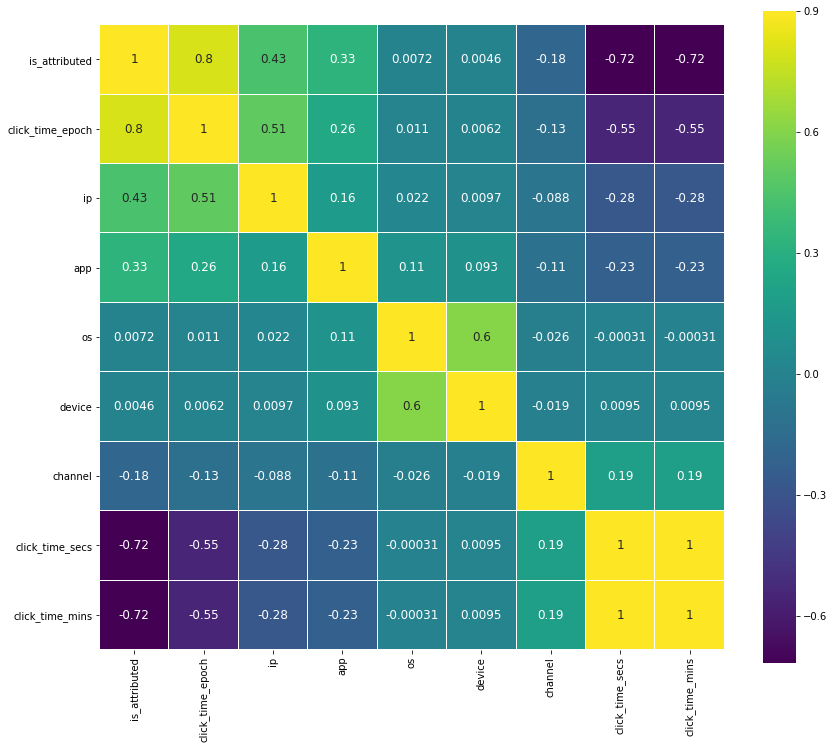

In [14]:
k = 11   # we'll look at the 11 largest correlations
correlation = data.corr()
cols = correlation.nlargest(k, 'is_attributed')['is_attributed'].index

print('The', k, 'columns with the highest correlation with fraud:')
print(list(cols))   # the k variables that correlate most highly with SalePrice

cm = np.corrcoef(data[cols].values.T)
f , ax = plt.subplots(figsize = (14, 12))
sns.heatmap(cm, 
            vmax = .9, 
            linewidths = 0.01, 
            square = True, 
            annot = True, 
            cmap = 'viridis',
            linecolor = "white", 
            xticklabels = cols.values, 
            annot_kws = {'size': 12}, 
            yticklabels = cols.values)

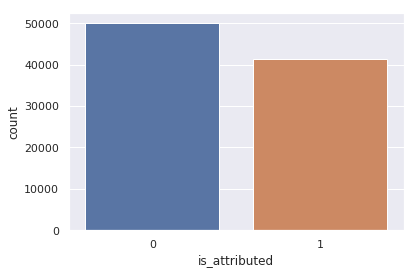

In [15]:
# Count of Fraudulent vs Non-Fraudulent
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="is_attributed", data=data)

This confirms that we have a major imbalance in our data. This is incentivising our model to guess 0 for overthing and it would still receive a 99% accuracy

# Logistic Regression

In [16]:
X = data[['app', 'device', 'os', 'channel', 'click_time_secs']]
y = data['is_attributed']

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [18]:
X_train.head()

,app,device,os,channel,click_time_secs
22243,2,1,20,477,61028
58933,105,1,17,451,33458
50574,18,3032,607,107,74066
63812,11,1,13,325,58608
52847,116,1,41,101,5858


In [19]:
y_train.head()

22243    0
58933    1
50574    0
63812    1
52847    1
Name: is_attributed, dtype: int64

In [20]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [21]:
logreg.fit(X_train, y_train)


/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
predictions = logreg.predict(X_test)

Seems a little strange that we would get such high accuracy. This might have to do with the fact that we are using R^2 to measure the goodness of our model. There might be an imbalance in the test set of which clicks are 0 or 1, so we should try precision and recall. (Longterm with full training data, try to keep an equal number of classes)

In [23]:
logreg_score = logreg.score(X_test, y_test)
print("Logistic Regression Accuracy", logreg_score)

Logistic Regression Accuracy 0.8567368133369773


# Random forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier()
RandomForest = RandomForest.fit(X_train,y_train)
rf_score = RandomForest.score(X_test,y_test)
print("Random Forest accuracy:", rf_score)

/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest accuracy: 0.9857338070511069


In [25]:
# Precision Recall Score
from sklearn.metrics import classification_report

y_pred = RandomForest.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9971
           1       0.99      0.98      0.98      8324

   micro avg       0.99      0.99      0.99     18295
   macro avg       0.99      0.99      0.99     18295
weighted avg       0.99      0.99      0.99     18295



In [26]:
#visualzie tree
from sklearn.tree import export_graphviz
#export_graphviz(RandomForest, out_file = 'tree.dot',feature_names=data.columns, )

In [27]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_test, y_pred)
plt.title("Confusion Matrix for Random Foreset")

annot = pd.DataFrame(cmat)

ax = sns.heatmap(cmat, annot=annot, fmt="d", xticklabels=['Actual No', 'Actual Yes'], yticklabels=['Predicted No', 'Predicted Yes'])
ax.tick_params(axis='y', rotation=0)

NameError: name 'Y_pred' is not defined

# Support Vector Machine

In [ ]:
from sklearn.svm import LinearSVC 

In [ ]:
lSVC = LinearSVC()

In [ ]:
lSVC.fit(X_train,y_train)
svm_score = lSVC.score(X_test,y_test)
print("SVM accuracy:", svm_score)

# Decision Tree

In [ ]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()

dtc = dtc.fit(X_train,y_train)
dtc_score =  dtc.score(X_test,y_test)
print("Decision Tree Accuracy:", dtc_score)

In [ ]:
# Precision Recall Score
from sklearn.metrics import classification_report

y_pred = dtc.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
# Confusion Matrix

#In Progress

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))
#plt.title("Confusion Matrix")

#plt.colorbar()
#tick_marks = np.arange(2)


# KNN

In [ ]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
knn_score = knn.score(X_test, y_test)


# Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
gaussian_score = gaussian.score(X_test, y_test) 

# SGD

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
sgd_score = sgd.score(X_test, y_test) 

# Perceptron

In [ ]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
perc_score = perceptron.score(X_test, y_test)


# XGBoost

In [95]:
#!pip3 install xgboost

    100% |████████████████████████████████| 114.0MB 48kB/s eta 0:00:011  76% |████████████████████████▍       | 86.8MB 1.6MB/s eta 0:00:18    79% |█████████████████████████▌      | 90.7MB 1.5MB/s eta 0:00:17    81% |██████████████████████████      | 92.8MB 1.6MB/s eta 0:00:14    81% |██████████████████████████▏     | 93.2MB 1.2MB/s eta 0:00:18    83% |██████████████████████████▋     | 94.7MB 4.9MB/s eta 0:00:04    84% |███████████████████████████     | 96.4MB 2.3MB/s eta 0:00:08    85% |███████████████████████████▏    | 97.0MB 710kB/s eta 0:00:24    85% |███████████████████████████▌    | 97.9MB 1.6MB/s eta 0:00:10    86% |███████████████████████████▋    | 98.3MB 962kB/s eta 0:00:17    86% |███████████████████████████▋    | 98.4MB 1.3MB/s eta 0:00:13    86% |███████████████████████████▋    | 98.5MB 2.2MB/s eta 0:00:07    86% |███████████████████████████▊    | 98.6MB 980kB/s eta 0:00:16    87% |███████████████████████████▉    | 99.2MB 1.7MB/s eta 0:00:09    87% |█████████████████████████

In [96]:
import xgboost as xgb

XGB = xgb.XGBClassifier()
XGB.fit(X_train, y_train)
Y_pred = XGB.predict(X_test)
XGB_score = XGB.score(X_test,y_test)


XGBoostError: XGBoost Library (libxgboost.so) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libgomp.so for UNIX-like OSes)
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['libgomp.so.1: cannot open shared object file: No such file or directory', 'libgomp.so.1: cannot open shared object file: No such file or directory']


In [ ]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_test, Y_pred)
plt.title("Confusion Matrix for XGBoost")

annot = pd.DataFrame(cmat)

ax = sns.heatmap(cmat, annot=annot, fmt="d", xticklabels=['Actual No', 'Actual Yes'], yticklabels=['Predicted No', 'Predicted Yes'])
ax.tick_params(axis='y', rotation=0)

In [ ]:
from xgboost import plot_tree


import graphviz
# Visualizing xgboost decisision trees using graphiviz library

# Visualizing the first boosted tree (least sophisticated)
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(XGB, ax=ax, num_trees=0 )
plt.show()

# Gradient Boosted Trees

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt = gbt.fit(X_train, y_train)
gbt_acc = gbt.score(X_test, y_test)

# Voting Classifier/ Ensemble Learning

In [30]:
from sklearn.ensemble import VotingClassifier

#dictionary of our models
model1 = xgb.XGBClassifier()
model2 = tree.DecisionTreeClassifier()
model3 = RandomForestClassifier() 
estimators=[(‘xgboost’, model1), (‘decisiontree’, model2), (‘randomforest’, model3)]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting=’hard’)
ensemble = ensemble.fit(X_train,y_train)
ensemble_acc = ensemble.score(X_test,y_test)

SyntaxError: invalid character in identifier (<ipython-input-30-5b707a9af998>, line 7)

# Adaboost

In [31]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=100)
adaboost = adaboost.fit(X_train,y_train)
adaboost_acc = adaboost.score(X_test,y_test)

# Bagging Classifer

In [32]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier()
bag = bag.fit(X_train,y_train)
bag_acc = bag.score(X_test,y_test)

# Extra Trees Classifier

In [35]:
from sklearn.ensemble import ExtraTreesClassifier
xtrees = ExtraTreesClassifier()
xtrees = xtrees.fit(X_train,y_train)
xtrees_acc = xtrees.score(X_test,y_test)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Which model do we use?

In [36]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Linear SVC', 
              'Decision Tree', 'K Nearest Neighbors', 
              'Gaussian Naive Bayes', 'Stochastic Gradient Descent', 
              'Perceptron', 'XGBoost', 'Gradient Boosted Trees', 'Adaboost', 
              'Bagging Classifier'],
    'Score': [svm_score, logreg_score, rf_score, svm_score, dtc_score, 
              knn_score, gaussian_score, sgd_score, perc_score, 
              XGB_score, gbt_acc, adaboost_acc, bag_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,0.986554
9,XGBoost,0.986116
10,Gradient Boosted Trees,0.986062
12,Bagging Classifier,0.985406
11,Adaboost,0.984641
4,Decision Tree,0.980432
5,K Nearest Neighbors,0.971850
6,Gaussian Naive Bayes,0.964799
7,Stochastic Gradient Descent,0.929762
0,Support Vector Machines,0.928286


# Neural Network

In [65]:
from keras.models import Sequential
from keras.layers import Dense

#60,30,1 --> .9156 acc with .234 loss
#20,10,1 --> .9122 acc, .2576 loss
#10,5,1 --> val: .9064 acc, .279 loss
#30,10,1 --> .9117 acc, .239 loss
#60,10,1 --> .918 acc , .230 loss
#70,10,1 --> .913, .238
#50,10,1 --> .917 , .229
#40,10,1 --> .918, .228
model = Sequential()
model.add(Dense(40, activation='sigmoid', input_dim = 4))
model.add(Dense(10,activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))


# can try rmsprop
model.compile(optimizer = 'adam',     
              loss = 'binary_crossentropy',
              metrics = ['accuracy']) 

# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, y_train, 
                    validation_split = 0.33, 
                    epochs = 300, 
                    batch_size = 32)

# Evaluate the model's performance
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)


print('Training set accuracy:', train_acc)
print('Training set loss:', train_loss)

print('Test set accuracy:', test_acc)
print('Test set loss:', test_loss)



Train on 49029 samples, validate on 24149 samples
Epoch 1/300
49029/49029 [==============================] - 5s 110us/step - loss: 0.5590 - acc: 0.6965 - val_loss: 0.5139 - val_acc: 0.7342
Epoch 2/300
49029/49029 [==============================] - 4s 78us/step - loss: 0.5006 - acc: 0.7707 - val_loss: 0.4792 - val_acc: 0.8164
Epoch 3/300
49029/49029 [==============================] - 4s 78us/step - loss: 0.4607 - acc: 0.8067 - val_loss: 0.4379 - val_acc: 0.8120
Epoch 4/300
49029/49029 [==============================] - 4s 78us/step - loss: 0.4272 - acc: 0.8247 - val_loss: 0.4006 - val_acc: 0.8413
Epoch 5/300
49029/49029 [==============================] - 4s 80us/step - loss: 0.3878 - acc: 0.8536 - val_loss: 0.3764 - val_acc: 0.8513
Epoch 6/300
49029/49029 [==============================] - 4s 88us/step - loss: 0.3601 - acc: 0.8679 - val_loss: 0.3415 - val_acc: 0.8700
Epoch 7/300
49029/49029 [==============================] - 4s 89us/step - loss: 0.3423 - acc: 0.8710 - val_loss: 0.3295 -

49029/49029 [==============================] - 3s 69us/step - loss: 0.2511 - acc: 0.9113 - val_loss: 0.2455 - val_acc: 0.9107
Epoch 118/300
49029/49029 [==============================] - 3s 69us/step - loss: 0.2503 - acc: 0.9114 - val_loss: 0.2432 - val_acc: 0.9129
Epoch 119/300
49029/49029 [==============================] - 3s 69us/step - loss: 0.2500 - acc: 0.9112 - val_loss: 0.2558 - val_acc: 0.9130
Epoch 120/300
49029/49029 [==============================] - 3s 70us/step - loss: 0.2511 - acc: 0.9110 - val_loss: 0.2449 - val_acc: 0.9139
Epoch 121/300
49029/49029 [==============================] - 3s 69us/step - loss: 0.2500 - acc: 0.9120 - val_loss: 0.2487 - val_acc: 0.9121
Epoch 122/300
49029/49029 [==============================] - 3s 70us/step - loss: 0.2496 - acc: 0.9112 - val_loss: 0.2400 - val_acc: 0.9128
Epoch 123/300
49029/49029 [==============================] - 3s 69us/step - loss: 0.2504 - acc: 0.9111 - val_loss: 0.2436 - val_acc: 0.9125
Epoch 124/300
49029/49029 [=======

49029/49029 [==============================] - 3s 70us/step - loss: 0.2401 - acc: 0.9153 - val_loss: 0.2341 - val_acc: 0.9169
Epoch 234/300
49029/49029 [==============================] - 3s 70us/step - loss: 0.2403 - acc: 0.9150 - val_loss: 0.2367 - val_acc: 0.9188
Epoch 235/300
49029/49029 [==============================] - 3s 70us/step - loss: 0.2397 - acc: 0.9152 - val_loss: 0.2363 - val_acc: 0.9167
Epoch 236/300
49029/49029 [==============================] - 3s 69us/step - loss: 0.2402 - acc: 0.9155 - val_loss: 0.2341 - val_acc: 0.9176
Epoch 237/300
49029/49029 [==============================] - 3s 70us/step - loss: 0.2410 - acc: 0.9143 - val_loss: 0.2360 - val_acc: 0.9165
Epoch 238/300
49029/49029 [==============================] - 3s 69us/step - loss: 0.2396 - acc: 0.9154 - val_loss: 0.2367 - val_acc: 0.9160
Epoch 239/300
49029/49029 [==============================] - 3s 69us/step - loss: 0.2398 - acc: 0.9152 - val_loss: 0.2356 - val_acc: 0.9189
Epoch 240/300
49029/49029 [=======

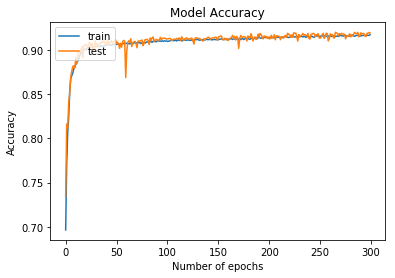

In [66]:
# The history of our accuracy during training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

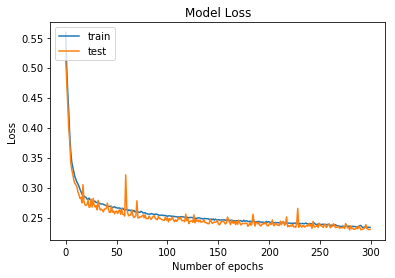

In [67]:
# The history of our cross-entropy loss during training.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Submitting to Kaggle with best model

In [28]:
true_test = pd.read_csv("data/test.csv")

# path has to be /fraud_detection/data/test.csv for docker
# path is data/test.csv for normal jupyter notebook command

In [29]:
true_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 7 columns):
click_id      int64
ip            int64
app           int64
device        int64
os            int64
channel       int64
click_time    object
dtypes: int64(6), object(1)
memory usage: 1003.5+ MB


In [30]:
#convert click_time to seconds since epoch
true_test['click_time_epoch'] =  true_test['click_time'].map(epoch_distance)



In [ ]:
# parsed `click_time` feature to seconds of the current day
# stored new column in `click_time_secs`
true_test['click_time_secs'] =  true_test['click_time_epoch'].map(day_seconds)

# parsed `click_time` feature to minutes of the current day
# stored new column in `click_time_mins`
true_test['click_time_mins'] =  true_test['click_time_epoch'].map(day_minutes)

In [ ]:
true_test.head()

In [ ]:
true_test_X = true_test[['app', 'device', 'os', 'channel','click_time_secs']]

true_test_X.head()

In [ ]:
true_test_predictions = RandomForest.predict(true_test_X)
submission = pd.DataFrame({
        "click_id,is_attributed": true_test_predictions
    }).to_csv('prediction.csv')
# saves to prediction.csv
